In [2]:
import pylab as plt
import arviz as az
import numpy as np
%matplotlib inline

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


### things I need to do:
1. read in samples [x]
2. select subset [x]
3. edit cigale params ini file [x]
4. run cigale [x]
5. read in seds
6. plot seds against data


In [3]:
field=['Lockman-SWIRE']

In [4]:
source=[0]

In [5]:
data=az.InferenceData.from_netcdf('./output/{}/prior_{}_{}.nc'.format(field[0],field[0],source[0]))

In [6]:
data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [130]:
def getSEDs(data,src,nsamp=30):
    import subprocess
    
    nsamp=30
    subsample=np.random.randint(low=0,high=data.posterior.chain.size*data.posterior.draw.size,size=nsamp)
    
    agn=data.posterior.agn.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]
    z=data.posterior.redshift.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]
    sfr=data.posterior.sfr.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]
    
    fin = open("/Volumes/pdh_storage/cigale/pcigale_orig.ini")
    fout = open("/Volumes/pdh_storage/cigale/pcigale.ini", "wt")
    for line in fin:
        if 'redshift =' in line:
            fout.write('    redshift = '+', '.join(['{:.7f}'.format(i) for i in z[:,src]])+' \n')
        elif 'fracAGN =' in line:
            fout.write('    fracAGN = '+', '.join(['{:.10f}'.format(i) for i in agn[:,src]])+' \n')
        else:
            fout.write(line)
    fin.close()
    fout.close()
    
    
    p = subprocess.Popen(['pcigale', 'run'], cwd='/Volumes/pdh_storage/cigale/')
    p.wait()
    
    SEDs=Table.read('/Volumes/pdh_storage/cigale/out//models-block-0.fits')
    #set more appropriate units for dust
    from astropy.constants import L_sun, M_sun
    SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
    SEDs['dust.mass']=SEDs['dust.mass']/M_sun.value
    
    wavelengths=[]
    fluxes=[]
    for i in range(0,nsamp):
        sed_plot=Table.read('/Volumes/pdh_storage/cigale/out/{}_best_model.fits'.format(+SEDs[i*nsamp+(i)]['id']))
        wavelengths.append(sed_plot['wavelength']/1E3)
        fluxes.append(((10.0**sfr[i,src])/SEDs[i*nsamp+(i)]['sfh.sfr'])*sed_plot['Fnu'])
    from astropy.table import vstack,hstack
    
    
    return hstack(wavelengths),hstack(fluxes)

In [131]:
w,f=getSEDs(data,30,nsamp=10)

In [29]:
nsamp=30
subsample=np.random.randint(low=0,high=data.posterior.chain.size*data.posterior.draw.size,size=nsamp)

In [107]:
agn=data.posterior.agn.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]
z=data.posterior.redshift.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]
sfr=data.posterior.sfr.values.reshape(data.posterior.chain.size*data.posterior.draw.size,data.posterior.src.size)[subsample,:]


In [72]:
src=0
fin = open("/Volumes/pdh_storage/cigale/pcigale_orig.ini")
fout = open("/Volumes/pdh_storage/cigale/pcigale.ini", "wt")
for line in fin:
    if 'redshift =' in line:
        fout.write('    redshift = '+', '.join(['{:.7f}'.format(i) for i in z[:,src]])+' \n')
    elif 'fracAGN =' in line:
        fout.write('    fracAGN = '+', '.join(['{:.10f}'.format(i) for i in agn[:,src]])+' \n')
    else:
        fout.write(line)
fin.close()
fout.close()

In [73]:
import subprocess
p = subprocess.Popen(['pcigale', 'run'], cwd='/Volumes/pdh_storage/cigale/')
p.wait()


0

In [77]:
from astropy.table import Table

In [81]:

SEDs=Table.read('/Volumes/pdh_storage/cigale/out//models-block-0.fits')
#set more appropriate units for dust
from astropy.constants import L_sun, M_sun
SEDs['dust.luminosity']=SEDs['dust.luminosity']/L_sun.value
SEDs['dust.mass']=SEDs['dust.mass']/M_sun.value

In [109]:
SEDs

id,IRAC1,megacam_g,megacam_i,megacam_r,megacam_u,megacam_y,megacam_z,mips_24,spire_250,spire_350,spire_500,dust.luminosity,dust.mass,sfh.sfr,stellar.m_star,agn.fracAGN,dust.qpah,dust.umin,universe.redshift
,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,mJy,W,kg,solMass / yr,solMass,,,,
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0,2.701861478880504e-14,1.6061159885921315e-17,1.817995344716483e-16,7.093236961319127e-17,1.7394026026934875e-18,1.9851617267763456e-16,3.489777052048158e-16,1.3685371357386896e-12,1.0003595835084217e-10,1.3151350971126994e-10,1.1557869026051836e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.7217095
1,1.8775913761123906e-14,7.338143805902348e-18,1.0530289136593338e-16,3.8463272088496e-17,4.176232459439559e-19,1.1518280651875063e-16,2.208828672822893e-16,9.710595646415571e-13,7.381287358950607e-11,1.0775460196020444e-10,1.0279962868230043e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,3.0213957
2,2.971349544774308e-14,1.9140837638792017e-17,2.0915478740522956e-16,8.301180995547178e-17,2.300274652232892e-18,2.273939460825944e-16,3.9261407481825235e-16,1.517970445554089e-12,1.0789554132864337e-10,1.3815637863452808e-10,1.1892730842996015e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.6482205
3,4.055639631830629e-14,3.6711957400638065e-17,3.403976159021166e-16,1.4497336652160434e-16,5.1838379313278024e-18,3.654783407776777e-16,6.332348685608073e-16,2.274336099251291e-12,1.4170217317850296e-10,1.6504780299783818e-10,1.315586051482402e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.3870008
4,3.327165900816645e-14,2.395595003145663e-17,2.4949829307988655e-16,1.0133128072565285e-16,3.2186971759311655e-18,2.702180120475929e-16,4.618513126758148e-16,1.7617757530397154e-12,1.190819801726753e-10,1.4732480618952412e-10,1.2340085217722767e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.5530102
5,4.3438554502655736e-14,4.228901722169283e-17,3.7739872379148645e-16,1.6346864928764575e-16,6.208642066573154e-18,4.046330174503553e-16,7.03822439231913e-16,2.4268045900186163e-12,1.5017158503096322e-10,1.7146465805930974e-10,1.343395023859883e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.33215
6,3.2065634804559395e-14,2.2184504924051406e-17,2.348771569920862e-16,9.475881747656848e-17,2.873714496931458e-18,2.5514924923135967e-16,4.3584342994506005e-16,1.6726594620232202e-12,1.1518219878032217e-10,1.4416363341922653e-10,1.218772769727637e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.5850642
7,2.50905281438158e-14,1.394272518566986e-17,1.6390661325497337e-16,6.323418831509989e-17,1.3798864061810292e-18,1.7854895334464826e-16,3.1971852503401447e-16,1.2700933618419328e-12,9.442192618186564e-11,1.2665084266060666e-10,1.1306903475830335e-10,31.99616305125483,0.017176376845766003,3.6011411610560557e-09,0.6968899218426303,0.071432516,1.12,10.0,2.7781129


In [82]:
i=0
SEDs[(SEDs['agn.fracAGN']==agn[i,src]) and (SEDs['universe.redshift']==z[i,src])]

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [85]:
agn[i,src]

0.071432516

In [112]:
i=0
nsamp=30
print(SEDs[i*nsamp+(i)][['id','agn.fracAGN','universe.redshift']],agn[i,src],z[i,src])

 id agn.fracAGN universe.redshift
--- ----------- -----------------
  0 0.071432516         2.7217095 0.071432516 2.7217095


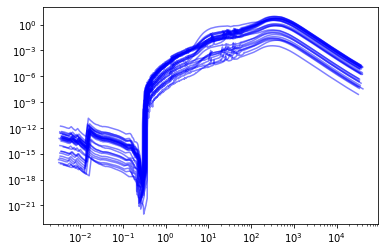

In [118]:
from astropy.io import fits
wavelengths=[]
fluxes=[]
for i in range(0,nsamp):
    sed_plot=Table.read('/Volumes/pdh_storage/cigale/out/{}_best_model.fits'.format(+SEDs[i*nsamp+(i)]['id']))
    wavelengths.append(sed_plot['wavelength']/1E3)
    fluxes.append(((10.0**sfr[i,src])/SEDs[i*nsamp+(i)]['sfh.sfr'])*sed_plot['Fnu'])
    plt.loglog(sed_plot['wavelength']/1E3,(10.0**sfr[i,src])/SEDs[i*nsamp+(i)]['sfh.sfr']*sed_plot['Fnu'],'b',alpha=0.5)

In [123]:
from astropy.table import vstack,hstack


In [125]:
hstack(wavelengths)

wavelength_1,wavelength_2,wavelength_3,wavelength_4,wavelength_5,wavelength_6,wavelength_7,wavelength_8,wavelength_9,wavelength_10,wavelength_11,wavelength_12,wavelength_13,wavelength_14,wavelength_15,wavelength_16,wavelength_17,wavelength_18,wavelength_19,wavelength_20,wavelength_21,wavelength_22,wavelength_23,wavelength_24,wavelength_25,wavelength_26,wavelength_27,wavelength_28,wavelength_29,wavelength_30
nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm,nm
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.0037217095,0.0040213956999999995,0.0036482205,0.0033870008,0.0035530102,0.00333215,0.0035850642000000003,0.0037781129,0.0034877074,0.004121716700000001,0.0039496341,0.0035084546,0.0031592469,0.0035254151999999997,0.0038768649,0.0032131109000000002,0.0039924431,0.0032569988,0.0038739338000000003,0.0035129554,0.0036091642,0.0034216552,0.0036592228,0.003402355,0.0037408187,0.0040789273,0.0037331371,0.0037331443000000004,0.0034332263,0.0033623991000000003
0.004175758058999999,0.004512005975399999,0.004093303400999999,0.0038002148975999996,0.0039864774444,0.0037386723,0.0040224420323999996,0.0042390426737999995,0.0039132077028,0.0046245661373999995,0.0044314894602,0.003936486061199999,0.0035446750217999995,0.003955515854399999,0.0043498424178,0.0036051104297999998,0.0044795211582,0.0036543526535999992,0.0043465537236,0.0039415359588,0.0040494822324,0.0038390971344,0.0041056479816,0.0038174423099999995,0.004197198581399999,0.004576556430599999,0.0041885798261999995,0.0041885879046,0.0038520799085999995,0.0037726117902
0.0046856322604999995,0.005062937186299998,0.004593109609499999,0.0042642340072,0.0044732398418,0.004195176849999999,0.0045135958278,0.0047566441411,0.0043910236166,0.0051892413253,0.004972589331899999,0.004417144341399999,0.003977491847099999,0.0044384977368,0.004880972909099999,0.0040453066231,0.0050264858628999995,0.0041005614892,0.0048772826542,0.004422810848599999,0.0045439377278,0.0043078638968,0.0046069615052000005,0.004283564944999999,0.0047096907432999996,0.0051353694707,0.0047000196089,0.0047000286737,0.0043224319117,0.0042332604669
0.0052587755235,0.0056822321241,0.0051549355665,0.0047858321304,0.005020403412600001,0.0047083279500000005,0.0050656957146,0.0053384735277,0.0049281305562,0.0058239856971,0.0055808329832999996,0.0049574463498,0.0044640158696999995,0.004981411677599999,0.0054780101037,0.0045401257017,0.0056413221003,0.0046021393044,0.0054738684594000005,0.0049638059802,0.005099749014600001,0.0048347987976,0.005170481816400001,0.0048075276149999995,0.0052857768231,0.0057635242749,0.005274922722300001,0.0052749328959,0.0048511487619,0.0047510699283
0.0058989095575,0.006373912184499999,0.0057824294924999995,0.005368396268,0.005631521167,0.005281457749999999,0.005682326757000001,0.0059883089465,0.0055280162290000006,0.0065329209695000005,0.0062601700485,0.005560900541,0.0050074063365,0.0055877830919999994,0.006144830866500001,0.0050927807765000005,0.0063280223135,0.005162343098,0.0061401850729999995,0.0055680343089999996,0.005720525256999999,0.005423323492,0.005799868138,0.005392732674999999,0.0059291976395,0.0064650997705,0.0059170223034999995,0.005917033715500001,0.0054416636855,0.0053294025735000005
0.006617199491,0.007150041554599999,0.006486536049,0.0060220874224,0.006317252135600001,0.0059245627,0.006374244147600001,0.0067174847362,0.006201143757200001,0.0073284122926,0.0070224494298,0.0062380322788,0.0056171409882,0.0062681882256,0.0068930657922,0.005712911180200001,0.0070985638318,0.0057909438664,0.006887854296400001,0.0062460347012,0.0064170939476,0.0060837029456,0.006506098138400001,0.00604938719,0.006651175648600001,0.007252332739400001,0.0066375177638,0.0066375305654,0.0061042763614,0.005978345599800001
0.007424810452499999,0.008022684421499997,0.0072781998975,0